# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

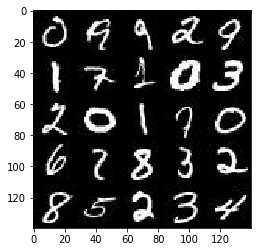

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

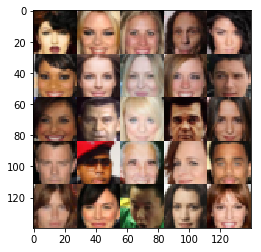

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(dtype=tf.float32, shape=(None,z_dim), name="input_z")
    learning_rate = tf.placeholder(dtype = tf.float32, name="learning_rate")                            
                             

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [106]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28 x 28 x #channels
        # Layer 1, no batch norm on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4 x 4 x 256

        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        # One output unit
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
   
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [107]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
        
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
    
        # Output should be 28 x 28 x out_channels
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1,(-1, 7,7, 512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 256

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        # 28 x 28 x 128
         
        # Output
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, padding='same')
        # 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [79]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    generator_model = generator(input_z, out_channel_dim)
    discriminator_real, discriminator_real_logits = discriminator(input_real)
    discriminator_fake, discriminator_fake_logits = discriminator(generator_model, reuse=True)
  
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.zeros_like(discriminator_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.ones_like(discriminator_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss , g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [80]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`


Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [101]:

class GAN:
    def __init__(self, real_size, z_dim, data_image_mode, beta1=0.5):
                   
        image_width = real_size[1]
        image_height = real_size[2]
        channels = real_size[3]

        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height,channels, z_dim)

        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,  channels)
       
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    net = GAN(data_shape, z_dim, data_image_mode)

    steps = 0

    print_every = 10
    show_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
   
                steps += 1
                # images are in range -0.5;0.5
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    channels = data_shape[3]
                    show_generator_output(sess,25, net.input_z, channels,data_image_mode)
        
        print("Final output")
        channels = get_channels(data_image_mode)
        show_generator_output(sess,25, net.input_z, channels,data_image_mode)


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0079... Generator Loss: 8.2789
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 7.8845
Epoch 1/2... Discriminator Loss: 0.0765... Generator Loss: 4.1991
Epoch 1/2... Discriminator Loss: 0.0839... Generator Loss: 4.2631
Epoch 1/2... Discriminator Loss: 0.4166... Generator Loss: 7.0094


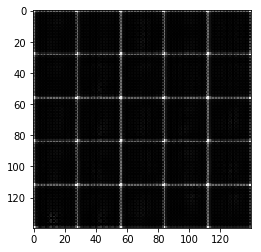

Epoch 1/2... Discriminator Loss: 1.6422... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.1417
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.4840
Epoch 1/2... Discriminator Loss: 1.5591... Generator Loss: 3.4773
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.7746


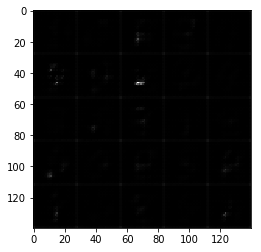

Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.2962
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 1.3690


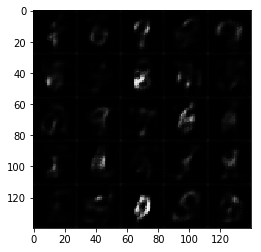

Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.9356
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 1.5201


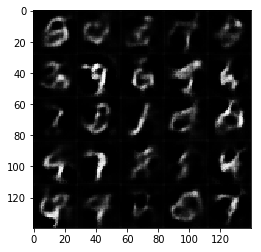

Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 1.3445
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 1.1759... Generator Loss: 1.4943
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 1.2122


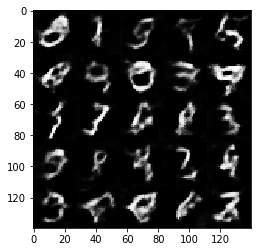

Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.4637
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.4631
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 1.4532


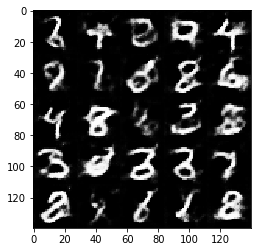

Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 1.5133
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.5248


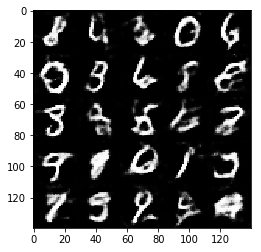

Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 1.7408
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.4195
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 0.6215


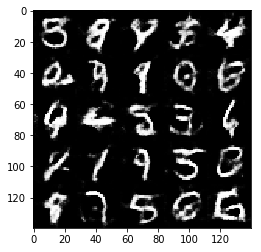

Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 1.5376
Epoch 2/2... Discriminator Loss: 1.1203... Generator Loss: 1.4320
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 0.9813


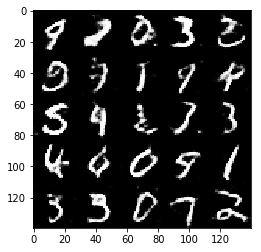

Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.6746
Final output


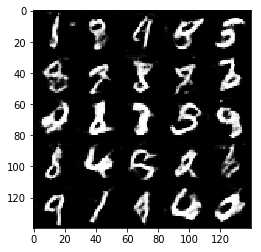

In [105]:
batch_size = 256
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 13.5799
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 3.7030
Epoch 1/1... Discriminator Loss: 0.0349... Generator Loss: 8.6549
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 9.8905
Epoch 1/1... Discriminator Loss: 0.0762... Generator Loss: 4.6518


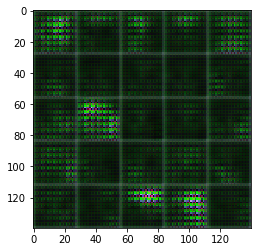

Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 5.8569
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.6446
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 2.6833


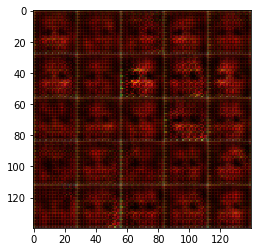

Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 0.3115... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 4.3253
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.7483


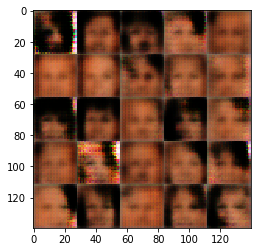

Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 0.9738


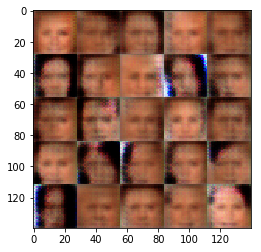

Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.5158
Epoch 1/1... Discriminator Loss: 1.6539... Generator Loss: 2.6017


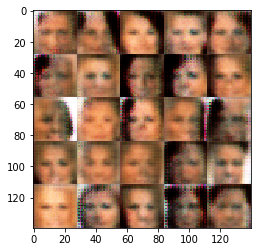

Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.8786
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.8239


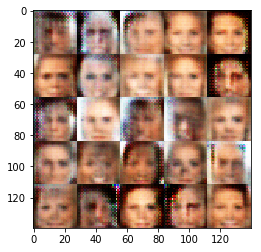

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.8216... Generator Loss: 0.2763
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.5859


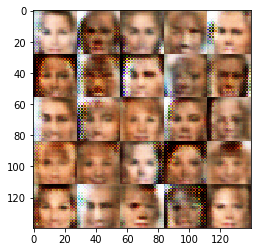

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 1.8250... Generator Loss: 0.2425
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.3489


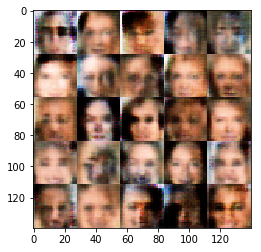

Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.5158
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.0761


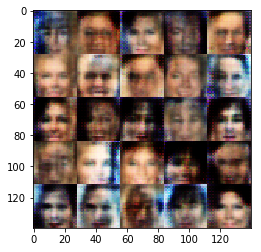

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.0359


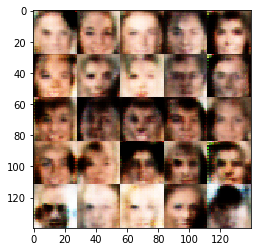

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6759


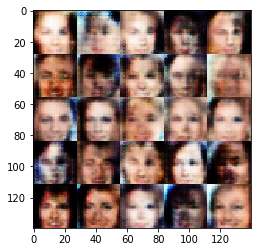

Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.6899... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 1.1158


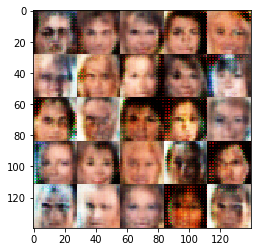

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 1.3726


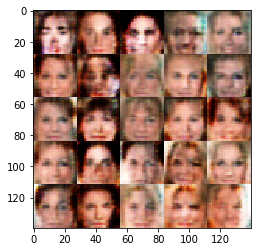

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 2.3635... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 1.0138


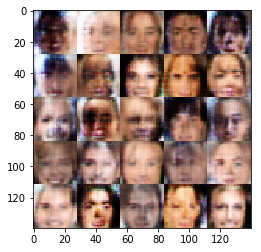

Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.7751... Generator Loss: 0.2596
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.0605


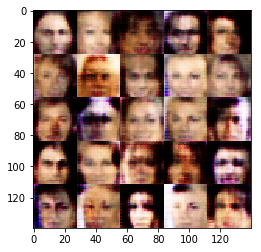

Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5355


KeyboardInterrupt: 

In [108]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.